<a href="https://colab.research.google.com/github/ncbx666/math_score_prediction/blob/main/cnn_lego_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_ = open("/content/sample_data/lego-test.pickle", "rb")
train_ = open("/content/sample_data/lego-train.pickle", "rb")

test_data = pickle.load(test_)
train_data = pickle.load(train_)

Так как мы работаем с фреймворком torch, переводим все массивы в тензоры.

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Преобразуем изображения и метки в тензоры
train_data_tensor = [(transform(img), label) for (img, label) in train_data]
test_data_tensor = [(transform(img), label) for (img, label) in test_data]

print(f"image size is {train_data_tensor[0][0].shape}")

image size is torch.Size([1, 48, 48])


Для наглядности смотрим на картинку.

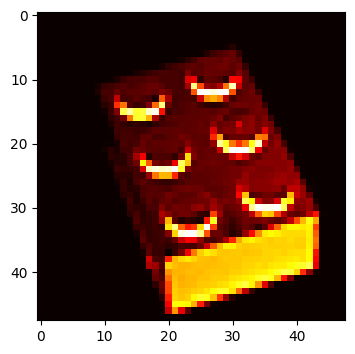

In [5]:
img = train_data_tensor[7][0].numpy()

plt.figure(figsize=(4, 4))
plt.imshow(img.transpose(1, 2, 0), cmap='hot')
plt.show()

In [6]:
train_loader = DataLoader(train_data_tensor, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data_tensor, batch_size=32, shuffle=False)

for i, batch in enumerate(train_loader):
  print(i, batch[1])
  break

0 tensor([3, 9, 4, 6, 0, 7, 5, 3, 1, 4, 9, 2, 6, 1, 7, 4, 9, 8, 9, 9, 5, 5, 7, 2,
        9, 0, 2, 4, 1, 3, 0, 3], dtype=torch.uint8)


In [7]:
#input 48x48x1
def create_cnn():
    model = nn.Sequential(
        # Первый сверточный слой: Conv2d, ReLU, AvgPool2d
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3),  # out: 46x46x6
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),  # out: 24x24x6
        nn.ReLU(),

        # Второй сверточный слой: Conv2d, ReLU
        nn.Conv2d(in_channels=6, out_channels=3, kernel_size=3),  # out: 21x21x3
        nn.ReLU(),

        # Второй слой пулинга: MaxPool2d
        nn.MaxPool2d(kernel_size=2, stride=2),  # out: 10x10x3

        # Растягиваем матрицу
        nn.Flatten(),

        # Подаем преобразованное изображение на вход FCL
        nn.Linear(10*10*3, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model


In [8]:
NUM_EPOCH = 100
LEARN_RATE = 0.01

In [9]:
def train_model(model, dataloader, device=device, num_epoch=NUM_EPOCH, learning_rate=LEARN_RATE):
  model = model.to(device)

  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

  acc_history = []


  for epoch in range(num_epoch):
          correct = 0
          total = 0

          for i, batch in enumerate(dataloader):
              images, labels = batch
              images = images.to(device)
              labels = labels.to(device)

              optimizer.zero_grad()

              # Считаем лосс
              predicted_labels = model(images)
              loss = loss_function(predicted_labels, labels)

              loss.backward()

              # Обновление параметров
              optimizer.step()

              # Подсчет точности
              _, predicted = predicted_labels.max(1) # По столбцам выбираем индекс с максимальной верояностью
              total += labels.size(0)
              correct += predicted.eq(labels).sum().item()

          # Точность по эпохе
          acc = correct / total
          acc_history.append(acc)

  return model, acc_history


In [10]:
model = create_cnn()

In [11]:
trained_model, acc = train_model(model, train_loader, device)

In [12]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

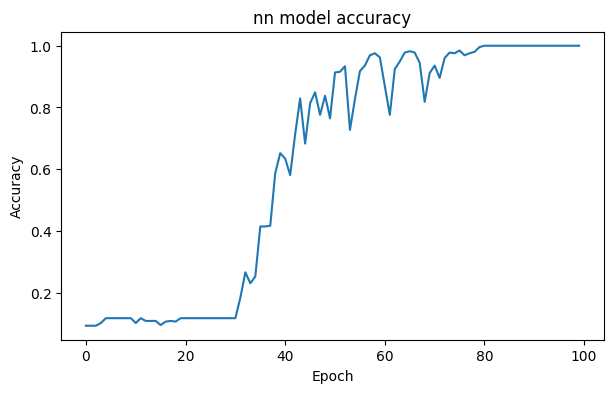

In [13]:
print_history(acc, 'nn model accuracy')

In [14]:
def evaluate_model(model, dataloader, device=device):
    model = model.to(device)
    model.eval()  # Устанавливаем модель в режим оценки

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            predicted_labels = model(images)

            _, predicted = predicted_labels.max(1)

            # Подсчитываем количество правильных предсказаний
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = correct / total

    return accuracy


Подсчитаем точность модели на тестовых данных.

In [16]:
acc_test = evaluate_model(trained_model, test_loader)

print(f"accuracy bsed on test data: {int(acc_test*100)}%")

accuracy bsed on test data: 100%
